In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
!pip install deep_sort_realtime opencv-python numpy torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 45.0 MB/s eta 0:00:00


In [ ]:
from ultralytics  import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import cv2
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 5am.mp4 to 5am (1).mp4


In [ ]:
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 79.2MB/s]


In [ ]:
cctv_feed = cv2.VideoCapture("5am.mp4")

In [ ]:
tracker = DeepSort(max_age=30, n_init=3)


0: 384x640 1 person, 1 train, 1 boat, 1 umbrella, 166.9ms
Speed: 7.2ms preprocess, 166.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Person ID 1: Bounding Box [       1719      939.35      3574.4      2245.4]


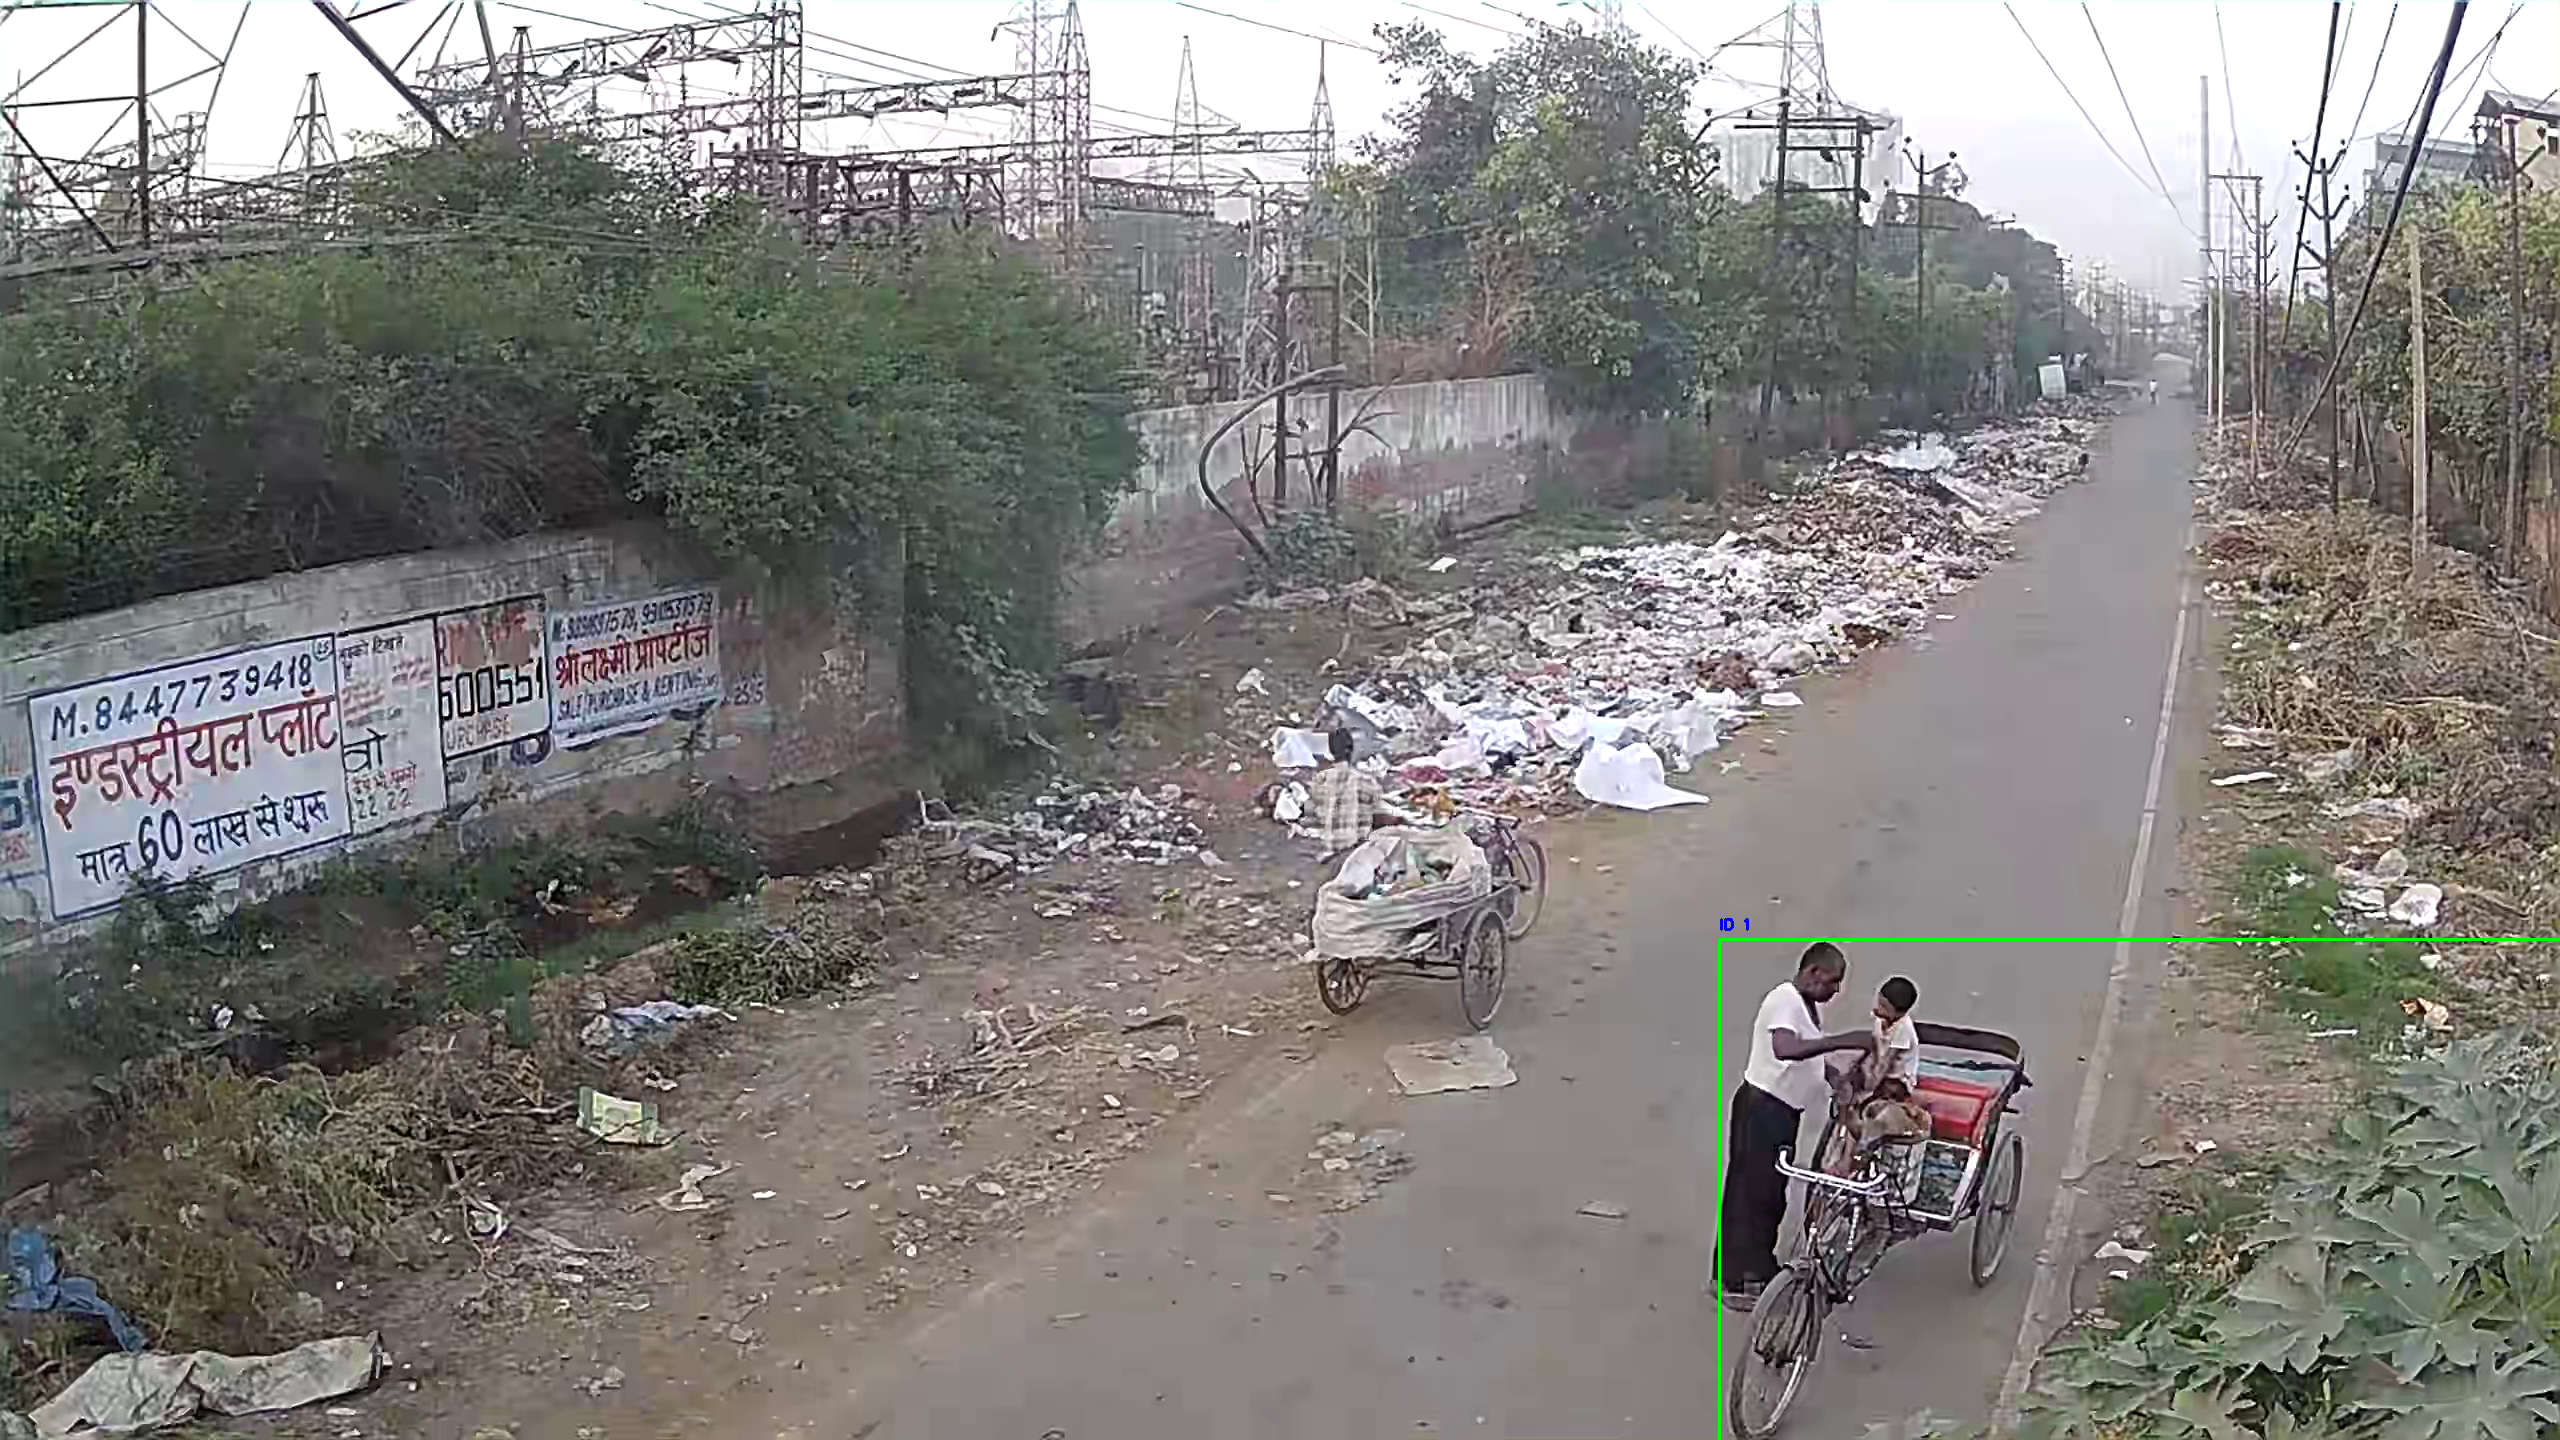

error: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window.cpp:1367: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'


In [ ]:
while cctv_feed.isOpened():
    ret, frame = cctv_feed.read()
    if not ret:
        break  # Stop when video ends

    # Run YOLO detection on the current frame
    results = model(frame)
    results = non_max_suppression(pred, conf_thres=0.4, iou_thres=0.5)


    # Store detected persons
    detections = []

    for r in results.xyxy[0]:  # Extract YOLO detections
        x1, y1, x2, y2, conf, cls = r.tolist()  # Convert to usable format

        if int(cls) == 0:  # Only process persons (class '0')
            detections.append(([x1, y1, x2, y2], conf))  # Store bounding box + confidence

    # Pass detections to DeepSORT tracker
    tracked_objects = tracker.update_tracks(detections, frame=frame)

    # Draw tracking IDs on the frame
    for obj in tracked_objects:
        if obj.is_confirmed():
            bbox = obj.to_tlbr()  # Convert bbox to (top-left, bottom-right)
            id = obj.track_id
            cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)
            cv2.putText(frame, f"ID {id}", (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Now loop through tracked objects (Only after they are defined)
    for obj in tracked_objects:
        if obj.is_confirmed():
               print(f"Person ID {obj.track_id}: Bounding Box {obj.to_tlbr()}")

    # Display the processed frame
    cv2.imshow("Tracking", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

    print(tracked_objects)